# Выбор локации для скважины

Добывающей компании «###» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План работы**

1. Загрузим и подготовим данные. Поясним порядок действий.
2. Обучим и проверим модель для каждого региона:
    1. Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучим модель и сделаем предсказания на валидационной выборке.
    3. Сохраним предсказания и правильные ответы на валидационной выборке.
    4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
    5. Проанализируем результаты.
3. Подготовим к расчёту прибыли:
    1. Все ключевые значения для расчётов сохраните в отдельных переменных.
    2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
    3. Напишем выводы по этапу подготовки расчёта прибыли.
4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выберем скважины с максимальными значениями предсказаний. 
    2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитаем прибыль для полученного объёма сырья.
5. Посчитаем риски и прибыль для каждого региона:
    1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    3. Напишем выводы: предложем регион для разработки скважин и обоснуем выбор.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
- `###.csv`
- `###.csv`
- `###.csv`
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1">Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2">Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3">Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4">Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1">Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">Общий вывод</a></span></li></ul></div>

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Константы
STATE = np.random.RandomState(12345)
POINTS = 500 # количество скважин, которое исследуют при разведке региона
BEST_FOR_ML = 200 # количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
BUDGET = 10e9 # бюджет (расходы) на разработку скважин в регионе, заложенный на 200 скважин
BARREL_PRICE = 450e3 # доход с каждой единицы продукта (рублей на 1 тыс. баррелей)
THRESHOLD = 0.025

In [ ]:
try:
    df1 = pd.read_csv('###_0.csv')
    df2 = pd.read_csv('###_1.csv')
    df3 = pd.read_csv('###_2.csv')
    
except:
    df1 = pd.read_csv('###_0.csv')
    df2 = pd.read_csv('###_1.csv')
    df3 = pd.read_csv('###_2.csv')

In [4]:
# Функция для получения общей информации о датасете
def get_info(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    data.hist(figsize=(15, 7), bins='auto')
    print('')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())

In [5]:
def corr_matrix(data):    
    corr_matrix = data.corr()
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347




Количество явных дубликатов: 0
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


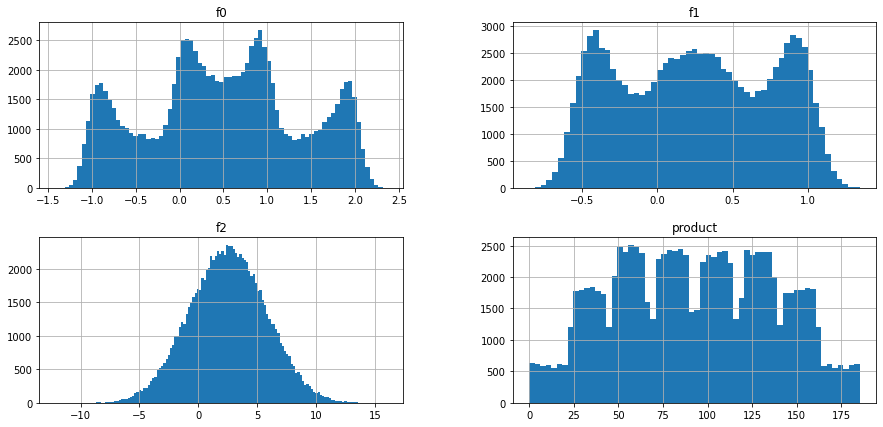

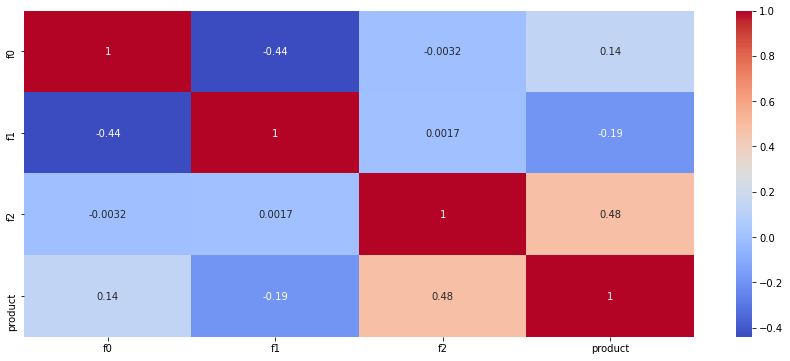

In [6]:
get_info(df1)
corr_matrix(df1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408




Количество явных дубликатов: 0
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


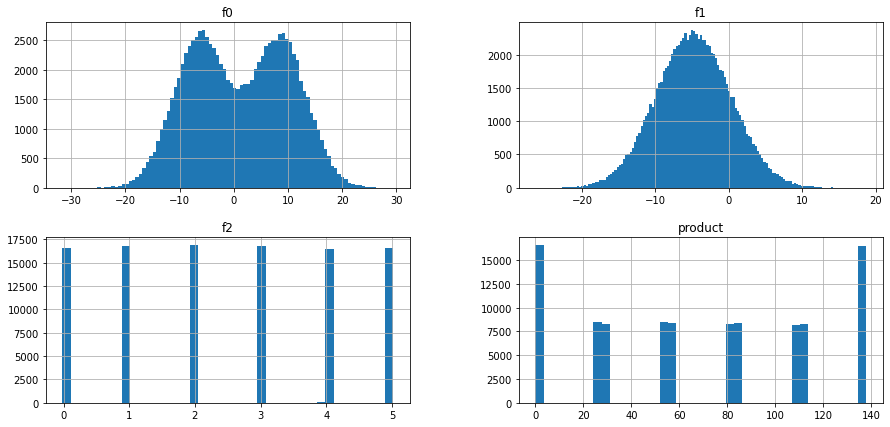

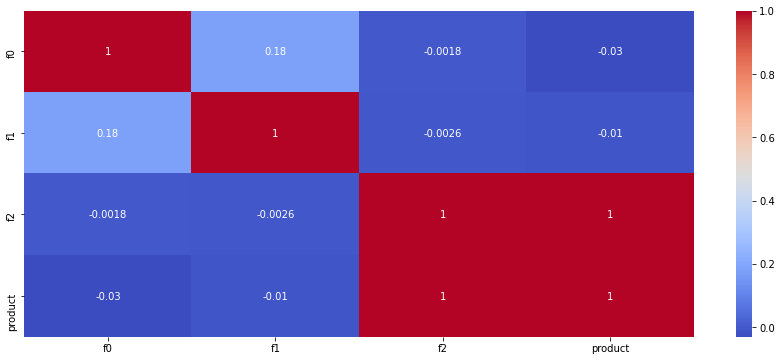

In [7]:
get_info(df2)
corr_matrix(df2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838




Количество явных дубликатов: 0
Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


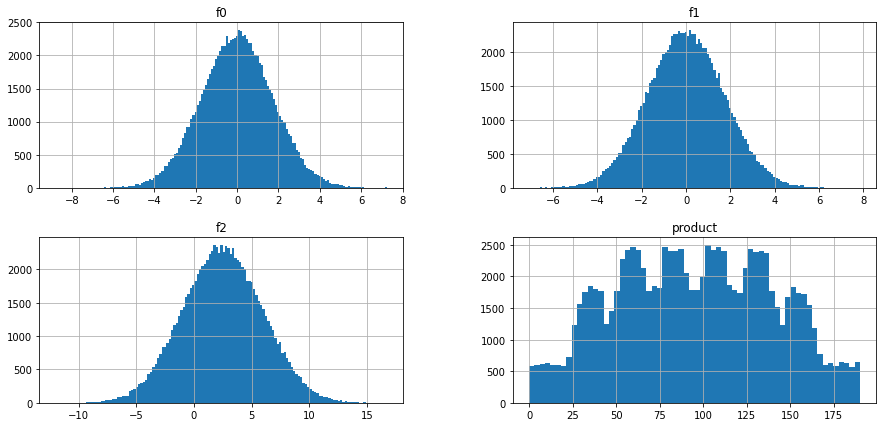

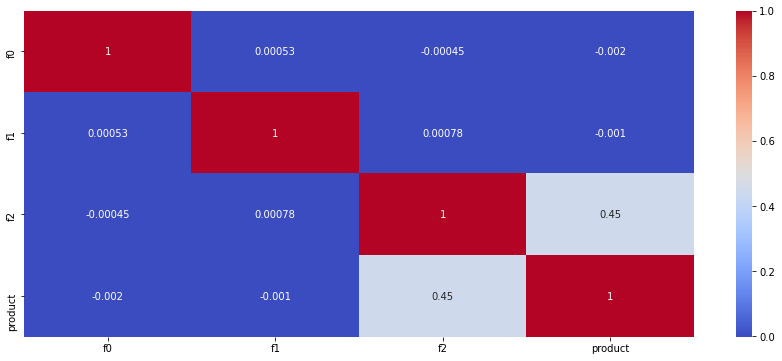

In [8]:
get_info(df3)
corr_matrix(df3)

Удалим из каждого датафрейма столбец id. Он не несет значимости для для модели.

In [9]:
data1 = df1.drop(['id'], axis=1)
data2 = df2.drop(['id'], axis=1)
data3 = df3.drop(['id'], axis=1)

### Вывод

- В данных отсутствуют пропуски и дубликаты
- Признаки `f0`, `f1`, `f2` не  имеют никакой взяимосвязи между собой. При этом признаки `f0` и `f1` не имеют какого-то значимого влияния на целевой признак, в то время как признак `f2` имеет среднюю взяимосвязь с целевым пизнаком в данных первого и третьего месторождений, а во втором месторождении между признаком `f2` и целевым признаком прослеживается прямая взаимосвязь. 
- Удалили из каждого датафрейма столбец `id`

## Обучение и проверка модели

In [10]:
names = ['data1', 'data2', 'data3']
data = [data1, data2, data3]

# создадим словарь для хранения фактического и предсказанных значений набора valid
targets = {}

for name, data in zip(names, data):
    target = data['product']
    features = data.drop('product', axis=1)
        
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=.25, random_state=STATE)
    
    # создадим pipeline их скелера и модели линейной регрессии
    model = make_pipeline(StandardScaler(), LinearRegression())
    
    model.fit(features_train, target_train)
    
    # запишем фактические данные и предсказанные в словарь
    targets[name] = (target_valid, pd.Series(model.predict(features_valid), \
                     index=target_valid.index, name='product_predicted'))
    
    # напечатаем на экране средний запас предсказанного сырья и RMSE модели
    print()
    print(f'Для {name} региона:')
    print(f'Средний запас предсказанного сырья = {targets[name][1].mean():.2f} тыс. баррелей')
    print(f'RMSE модели = {(mean_squared_error(target_valid, targets[name][1])**0.5):.2f}')


Для data1 региона:
Средний запас предсказанного сырья = 92.59 тыс. баррелей
RMSE модели = 37.58

Для data2 региона:
Средний запас предсказанного сырья = 68.77 тыс. баррелей
RMSE модели = 0.89

Для data3 региона:
Средний запас предсказанного сырья = 95.09 тыс. баррелей
RMSE модели = 39.96


### Вывод

В данной части работы мы провели обучение и проверку модели. RMSE для датасета `data2` составляет 0.89. Однако, для датасетов `data1` и `data3` RMSE значительно выше и составляет 37.58 и 39.96 соответственно. Это говорит о том, что в этих датасетах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью. Предварительно можно утверждать, что, по результатам предсказаний моделей линейной регрессии, регион `data2` является самым предсказуемым, но низкодоходным, а `data3`самым доходным и рискованным.

## Подготовка к расчёту прибыли

In [11]:
names = ['data1', 'data2', 'data3']
data = [data1, data2, data3]
break_even = BUDGET / (BARREL_PRICE * BEST_FOR_ML)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, data in zip(names, data):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')

Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в data1 регионе = 92.50 тыс. баррелей.

Средний запас в data2 регионе = 68.83 тыс. баррелей.

Средний запас в data3 регионе = 95.00 тыс. баррелей.


### Вывод

Объём сырья для безубыточной разработки новой скважины равен 111.11 тысяч баррелей. Средний объем запасов скважин во всех регионах меньше этого значения.В регионе `data2` наша модель очень хорошо прогнозирует запасы скважин, хотя средние запасы меньше необходимых почти в 1,5 раза и составляют 68.83 тысяч баррелей. Разработку всех скважин вести нерентабельно, из всех скважин нужно выбрать всего 200 лучших с максимальными запасами.

## Расчёт прибыли и рисков 

In [12]:
#функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)[:count]
    selected = target[probs_sorted.index]
    product = selected.sum()
    revenue = product * BARREL_PRICE
    return revenue - BUDGET

In [14]:
for name in names: 
    values = []
    for _ in range(1000):
        target_subsample = targets[name][0].sample(POINTS, replace=True, random_state=STATE)
        probs_subsample = targets[name][1][target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, BEST_FOR_ML))

    values = pd.Series(values)

    mean = values.mean() / 1e6
    lower = values.quantile(0.025) / 1e6
    upper = values.quantile(0.975) / 1e6

    risk = values.apply(lambda x: x < 0).sum() / len(values)

    print()
    print(f'Для {name} региона:')
    print(f'Средняя прибыль с 200 лучших скважин, отобранных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')


Для data1 региона:
Средняя прибыль с 200 лучших скважин, отобранных по предсказанию = 595 млн. рублей.
Доверительный интервал лежит между -32 - 1289 млн. рублей.
Риск убытков составляет = 3.60%

Для data2 региона:
Средняя прибыль с 200 лучших скважин, отобранных по предсказанию = 662 млн. рублей.
Доверительный интервал лежит между 160 - 1237 млн. рублей.
Риск убытков составляет = 0.10%

Для data3 региона:
Средняя прибыль с 200 лучших скважин, отобранных по предсказанию = 546 млн. рублей.
Доверительный интервал лежит между -37 - 1169 млн. рублей.
Риск убытков составляет = 3.70%


### Вывод

Отсеиваем регионы `data1` и `data3`, так как риски убытков относительно велики (3.6% и 3.7%).
В регионе `data2` вероятность убытков меньше 2.5% и составляет 0.1%, cредняя прибыль составляет более 662 млн. рублей, 95%-й доверительный интервал не содержит отрицательных значений. Несмотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин в регионе `data2` прогнозируется выше других при наименьшем риске убытков.

## Общий вывод

В ходе исследования построена модель машинного обучения, которая помогла определить регион, где добыча принесёт наибольшую прибыль, проведен анализ возможной прибыли и рисков техникой Bootstrap.

На этапе **загрузки и подготовки данных** установлено:
- В данных отсутствуют пропуски и дубликаты
- Признаки `f0`, `f1`, `f2` не имеют никакой взяимосвязи между собой. При этом признаки `f0` и `f1` не имеют какого-то значимого влияния на целевой признак, в то время как признак `f2` имеет среднюю взяимосвязь с целевым пизнаком в данных первого и третьего месторождений, а во втором месторождении между признаком `f2` и целевым признаком прослеживается прямая взаимосвязь.
- Удалили из каждого датафрейма столбец `id`

На этапе **обучения и проверки данных** установлено, что RMSE для датасета `data2` составляет 0.89. Для датасетов `data1` и `data3` RMSE значительно выше и составляет 37.58 и 39.96 соответственно. Это говорит о том, что в этих датасетах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью. По результатам предсказаний моделей линейной регрессии, регион `data2` является самым предсказуемым, но низкодоходным, а `data3` самым доходным и рискованным.

На этапе **подготовки к расчету прибыли** установили, что объём сырья для безубыточной разработки новой скважины равен 111.11 тысяч баррелей. Средний объем запасов скважин во всех регионах меньше этого значения.В регионе `data2` наша модель очень хорошо прогнозирует запасы скважин, хотя средние запасы меньше необходимых почти в 1,5 раза и составляют 68.83 тысяч баррелей. Разработку всех скважин вести нерентабельно, из всех скважин нужно выбрать всего 200 лучших с максимальными запасами.

На этапе **расчета прибыли и рисков** отсеили регионы `data1` и `data3`, так как риски убытков относительно велики (3.6% и 3.7%). В регионе `data2` вероятность убытков меньше 2.5% и составляет 0.1%, cредняя прибыль составляет более 662 млн. рублей, 95%-й доверительный интервал не содержит отрицательных значений. Несмотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин в регионе `data2` прогнозируется выше других при наименьшем риске убытков.

 
**Исходя из проведённого анализа, можно предположить, что наиболее выгодным для разработки является регион `data2`.**